In [1]:
# Import libraries
import os
import pandas as pd
import numpy as np
import time
import json

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline

### Get sugar indexes of the selected field

In [2]:
# Assumption: We already know the tile in which the chosen field belongs to.
pos = 'x6144-y5632'

# Initialise a tile dataframe
df_tile = pd.DataFrame(columns=['x', 'y', 'cen_lat', 'cen_lon', 'field_sugar_pixel', 'sugar_pixel'])
df_tile['x'] = np.repeat(range(512),512)
df_tile['y'] = np.tile(range(512),512)
df_tile['field_sugar_pixel'] = 0
df_tile

,x,y,cen_lat,cen_lon,field_sugar_pixel,sugar_pixel
0,0,0,NaN,NaN,0,NaN
1,0,1,NaN,NaN,0,NaN
2,0,2,NaN,NaN,0,NaN
3,0,3,NaN,NaN,0,NaN
4,0,4,NaN,NaN,0,NaN
...,...,...,...,...,...,...
262139,511,507,NaN,NaN,0,NaN
262140,511,508,NaN,NaN,0,NaN
262141,511,509,NaN,NaN,0,NaN
262142,511,510,NaN,NaN,0,NaN


In [3]:
# Import sugar mask and get sugar pixels
sugar_mask = mpimg.imread('../../data/masks/mask-' + pos + '.png')
flat_mask = list(sugar_mask.reshape((512*512, 3)))
sugar_pixel = [1 if (pixel == [0,0,0]).all() else 0 for pixel in flat_mask]

# Add sugar pixels to tile dataframe
df_tile.loc[:, 'sugar_pixel'] = sugar_pixel
df_tile

,x,y,cen_lat,cen_lon,field_sugar_pixel,sugar_pixel
0,0,0,NaN,NaN,0,1
1,0,1,NaN,NaN,0,1
2,0,2,NaN,NaN,0,1
3,0,3,NaN,NaN,0,1
4,0,4,NaN,NaN,0,1
...,...,...,...,...,...,...
262139,511,507,NaN,NaN,0,0
262140,511,508,NaN,NaN,0,0
262141,511,509,NaN,NaN,0,0
262142,511,510,NaN,NaN,0,0


In [4]:
# Get coordinates for each pixel from the geojson file of the tile
geojson_path = '../../data/geometries/geo-' + pos + '.geojson'
with open(geojson_path) as f:
    data = json.load(f)
    coordinates = data['features'][0]['geometry']['coordinates']
    lon_1 = coordinates[0][1][0]
    lat_1 = coordinates[0][1][1]
    lon_2 = coordinates[0][3][0]
    lat_2 = coordinates[0][3][1]
    
print((lat_1, lon_2), (lat_2, lon_1))

(-20.39753047953282, 148.54754734569403) (-20.444226638274003, 148.59613801107028)


In [5]:
# Get central lat and lon for each pixel in the tile
lat_list = np.linspace(lat_1, lat_2, num=513)
lon_list = np.linspace(lon_2, lon_1, num=513)

cen_lat_list = []
for i in range(512):
    cen_lat = (lat_list[i] + lat_list[i+1])/2
    cen_lat_list.append(cen_lat)
    
cen_lon_list = []
for i in range(512):
    cen_lon = (lon_list[i] + lon_list[i+1])/2
    cen_lon_list.append(cen_lon)

# Add pixel coordinates to the tile datframe
df_tile['cen_lat'] = np.repeat(cen_lat_list, 512)
df_tile['cen_lon'] = np.tile(cen_lon_list, 512)
df_tile

,x,y,cen_lat,cen_lon,field_sugar_pixel,sugar_pixel
0,0,0,-20.397576,148.547595,0,1
1,0,1,-20.397576,148.547690,0,1
2,0,2,-20.397576,148.547785,0,1
3,0,3,-20.397576,148.547880,0,1
4,0,4,-20.397576,148.547974,0,1
...,...,...,...,...,...,...
262139,511,507,-20.444181,148.595711,0,0
262140,511,508,-20.444181,148.595806,0,0
262141,511,509,-20.444181,148.595901,0,0
262142,511,510,-20.444181,148.595996,0,0


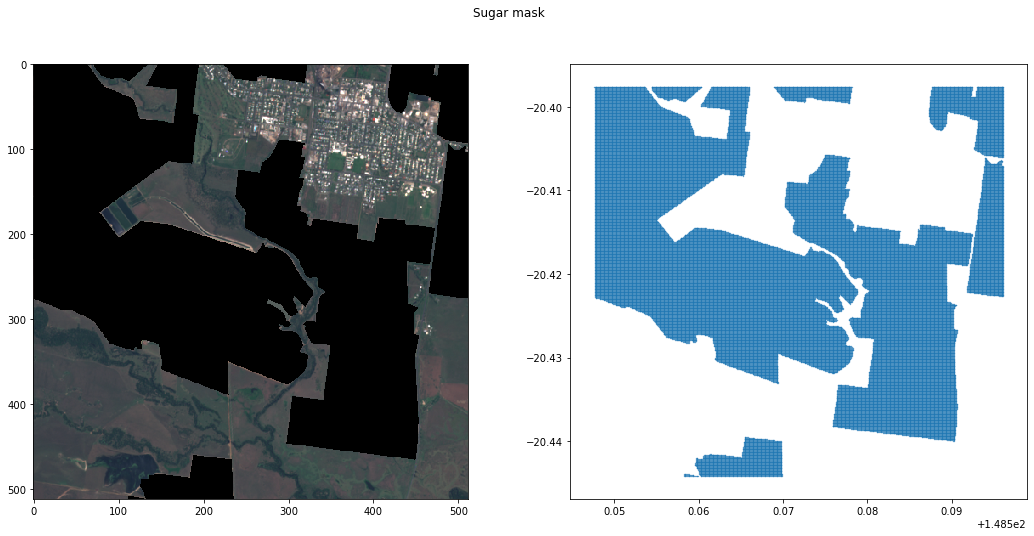

In [6]:
# Filter sugar pixels only
df_sugar = df_tile[df_tile['sugar_pixel']==1]

# Plot sugar mask
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8))
fig.suptitle('Sugar mask')
ax1.imshow(sugar_mask)
ax2.scatter(df_sugar['cen_lon'], df_sugar['cen_lat'], s=0.1)
plt.show()

In [7]:
# Import the selected field
plt.rcParams['figure.figsize'] = (8, 8)
selected_field = gpd.read_file('./Geojson/COURSE_28818554.geojson')

In [8]:
# Find all sugar pixels which belong to the selected field
field_sugar_index = []
for i in df_sugar.index:
    lat = df_sugar.loc[i,'cen_lat']
    lon = df_sugar.loc[i,'cen_lon']
    if selected_field.contains(Point(lon, lat))[0]:
        field_sugar_index.append(i)
        
print('There are', len(field_sugar_index), 'sugar pixels in this field.')
        
# Save the sugar index of selected field
with open("COURSE_28818554_sugar_index.csv", "wb") as f:
    np.savetxt(f, np.array(field_sugar_index).astype(int), fmt='%i', delimiter=",")

There are 3647 sugar pixels in this field.


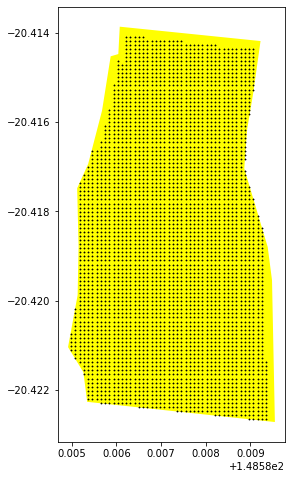

In [9]:
# Plot the field
selected_field.plot(color='yellow')
plt.scatter(df_tile.loc[field_sugar_index,'cen_lon'], df_tile.loc[field_sugar_index,'cen_lat'], s=1, marker='*', color='black')
plt.show()

### Get time-series NDVI of the selected field

In [14]:
# Get all ndvi file names
ndvi_dir = '../../data/phase-02/tile-x6144-y5632/sen-ndvi/'
ndvi_list = os.listdir(ndvi_dir)
ndvi_list = [ndvi for ndvi in ndvi_list if 'csv' in ndvi]
ndvi_list[0:5]

['sen-ndvi-x6144-y5632-2015-11-18.csv',
 'sen-ndvi-x6144-y5632-2015-11-28.csv',
 'sen-ndvi-x6144-y5632-2016-02-06.csv',
 'sen-ndvi-x6144-y5632-2016-03-07.csv',
 'sen-ndvi-x6144-y5632-2016-03-27.csv']

In [15]:
# Get the list of dates
dates = [ndvi[-14:-4] for ndvi in ndvi_list]
len(dates)

214

In [16]:
# Get timeseries NDVI of the tile
tile_ndvi = pd.DataFrame(columns=['nan-1']+dates+['nan-2'])

for i in range(len(dates)):
    date = dates[i]
    ndvi_file = ndvi_list[i]
    ndvi_path = ndvi_dir + '/' + ndvi_file
    ndvi = np.genfromtxt(ndvi_path, delimiter=',')
    tile_ndvi[date] = ndvi.reshape(512*512)

# Have a look
tile_ndvi.head()

,nan-1,2015-11-18,2015-11-28,2016-02-06,2016-03-07,2016-03-27,2016-04-06,2016-04-16,2016-04-26,2016-05-06,...,2019-09-18,2019-09-23,2019-09-28,2019-10-03,2019-10-08,2019-10-13,2019-10-18,2019-10-23,2019-10-28,nan-2
0,NaN,NaN,NaN,NaN,0.656922,NaN,0.666951,0.692308,0.640382,NaN,...,0.216175,NaN,0.229741,0.291194,0.259308,0.312123,0.311431,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,0.686752,NaN,0.705750,0.709378,0.666491,NaN,...,0.190589,NaN,0.216238,0.266208,0.253432,0.291601,0.310699,0.208246,NaN,NaN
2,NaN,NaN,NaN,NaN,0.670930,NaN,0.689549,0.700754,0.650040,NaN,...,0.179953,NaN,0.218264,0.260624,0.242727,0.285371,0.289061,0.217192,NaN,NaN
3,NaN,NaN,NaN,NaN,0.641994,NaN,0.685780,0.691797,0.649921,NaN,...,0.176593,NaN,0.208002,0.254154,0.237042,0.276071,0.283906,0.240257,NaN,NaN
4,NaN,NaN,NaN,NaN,0.620221,NaN,0.690334,0.695495,0.651282,NaN,...,0.175959,NaN,0.205846,0.252214,0.221739,0.259804,0.271944,0.255137,NaN,NaN


In [17]:
# Initialise field NDVI dataframe
field_ndvi_only = pd.DataFrame(columns=tile_ndvi.columns, index = range(len(tile_ndvi)))

# Filter out sugar pixels that not in the selected field
for i in field_sugar_index:
    field_ndvi_only.iloc[i,] = tile_ndvi.iloc[i,]

field_ndvi_only.iloc[field_sugar_index,]

,nan-1,2015-11-18,2015-11-28,2016-02-06,2016-03-07,2016-03-27,2016-04-06,2016-04-16,2016-04-26,2016-05-06,...,2019-09-18,2019-09-23,2019-09-28,2019-10-03,2019-10-08,2019-10-13,2019-10-18,2019-10-23,2019-10-28,nan-2
93079,NaN,NaN,NaN,NaN,NaN,0.733067,0.691147,0.732191,0.585738,NaN,...,0.527671,0.436192,NaN,NaN,0.504929,0.542369,0.503721,0.58172,NaN,NaN
93080,NaN,NaN,NaN,NaN,NaN,0.77011,0.738832,0.76208,0.63477,0.524066,...,0.569024,NaN,NaN,NaN,0.526107,0.550608,0.50357,0.585404,NaN,NaN
93081,NaN,NaN,NaN,NaN,NaN,0.766599,0.735595,0.759822,0.631068,0.542846,...,0.566719,NaN,NaN,NaN,0.528266,0.550521,0.495537,0.574663,NaN,NaN
93082,NaN,NaN,NaN,NaN,NaN,0.76532,0.732897,0.752888,0.638875,0.546108,...,0.574303,NaN,NaN,NaN,0.529699,0.543603,0.489937,0.563056,NaN,NaN
93083,NaN,NaN,NaN,NaN,0.434177,0.766082,0.735328,0.753576,0.633892,0.543295,...,0.565011,NaN,NaN,NaN,0.513767,0.529381,0.486766,0.558636,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141236,NaN,NaN,NaN,NaN,0.700757,NaN,0.742982,0.767583,0.6875,0.589275,...,0.235661,0.232937,0.184621,NaN,0.210668,0.231184,0.242509,0.317446,0.306716,NaN
141237,NaN,NaN,NaN,NaN,0.71907,NaN,0.739678,0.761998,0.697992,0.589373,...,0.246093,0.219076,0.193929,NaN,0.214381,0.241395,0.263757,0.35544,0.345566,NaN
141238,NaN,NaN,NaN,NaN,0.749535,NaN,0.731639,0.747493,0.68551,NaN,...,0.247578,0.205716,0.20195,NaN,0.224122,0.238844,0.287417,0.358001,0.373633,NaN
141239,NaN,NaN,NaN,NaN,0.759308,NaN,0.704251,0.736908,0.675244,NaN,...,0.235845,0.193663,0.198104,NaN,0.214095,0.229354,0.27187,0.33284,0.354998,NaN


There are several days where the field was totally covered by cloud, so that NDVI values for these days would equal -1. We should remove these days from timeseries NDVI data.

In [18]:
# Find all cloud cover days
drop_columns = list(field_ndvi_only.columns[np.mean(field_ndvi_only)==-1])
field_ndvi_only.loc[field_sugar_index,drop_columns]

,2018-11-05,2018-11-07,2018-11-10
93079,-1,-1,-1
93080,-1,-1,-1
93081,-1,-1,-1
93082,-1,-1,-1
93083,-1,-1,-1
...,...,...,...
141236,-1,-1,-1
141237,-1,-1,-1
141238,-1,-1,-1
141239,-1,-1,-1


In [19]:
# Drop the days
field_ndvi_only.drop(columns=drop_columns, inplace=True)

# Save time-series NDVI data of the field
field_ndvi_only.to_csv('COURSE_28818554_ndvi.csv', index=False)